# Import Modules

In [1]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [1]:
import datetime
import itertools
from itertools import islice
import json
import math
import os
import pickle
import random
import re
import sys
import time
import warnings
from functools import reduce
import torch

# import adjustText
import black
import matplotlib.pyplot as plt
import nba_api
import numpy as np
import pandas as pd
import requests
import seaborn as sns
import sklearn
import xgboost as xgb
import missingno as mno
from joblib import Memory
from random import sample
# from colabcode import ColabCode

from nba_api.stats.endpoints import (
    LeagueDashPlayerPtShot,
    LeagueDashPlayerShotLocations,
    LeagueDashPtStats,
    PlayerDashPtShots,
    leaguedashplayerstats,
    leaguedashteamstats,
    synergyplaytypes,
)
from nba_api.stats.endpoints.teamplayeronoffsummary import TeamPlayerOnOffSummary
from nba_api.stats.static.teams import get_teams
from nba_stats_tracking.models import tracking
from scipy import stats
from sklearn import set_config, svm
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import (
    BayesianRidge,
    ElasticNet,
    Lasso,
    LinearRegression,
    Ridge,
    SGDRegressor,
)
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import (
    KFold,
    RandomizedSearchCV,
    StratifiedShuffleSplit,
    cross_val_score,
    train_test_split,
    RepeatedKFold,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import MinMaxScaler, PowerTransformer
from sklearn.tree import DecisionTreeRegressor

os.environ["TOKENIZERS_PARALLELISM"] = "false"

use_cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if use_cuda else "cpu")

In [2]:
use_cuda

False

In [3]:
pip freeze

adjustText==0.8
aiohttp==3.8.5
aiosignal @ file:///tmp/build/80754af9/aiosignal_1637843061372/work
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
anaconda-client @ file:///opt/concourse/worker/volumes/live/866d4dd0-ff5b-4d0b-718d-0267a3b10e06/volume/anaconda-client_1635342573767/work
anaconda-navigator==2.3.2
anaconda-project @ file:///tmp/build/80754af9/anaconda-project_1637161053845/work
anyio @ file:///opt/concourse/worker/volumes/live/485b0f52-1188-482a-6285-65a36c8fa8a6/volume/anyio_1644481714856/work/dist
appdirs==1.4.4
applaunchservices @ file:///Users/ktietz/demo/mc3/conda-bld/applaunchservices_1630511705208/work
appnope @ file:///opt/concourse/worker/volumes/live/6ca6f098-d773-4461-5c91-a24a17435bda/volume/appnope_1606859448531/work
appscript @ file:///opt/concourse/worker/volumes/live/00049ed6-6263-4a6e-72b9-9d990f6e2f07/volume/appscript_1611427000595/work
argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work
argon2-cffi-bindings @ file

# Loading & Saving Data

In [20]:
# pickle.dump(data_dict, open('last_decade_data.pickle', 'wb'))

data_dict = pd.read_pickle(r"last_decade_data.pickle")

In [8]:
# pickle.dump(merged_df, open('merged_df.pickle', 'wb'))

merged_df = pd.read_pickle(r"merged_df.pickle")

In [3]:
# pickle.dump(merged_selected_features_df, open('merged_selected_features_df.pickle', 'wb'))

merged_selected_features_df= pd.read_pickle(r"merged_selected_features_df.pickle")

In [3]:
# pickle.dump(deter_data ,open('deterministic_imputed_merged_df.pickle', 'wb'))

deter_data= pd.read_pickle(r"deterministic_imputed_merged_df.pickle")


# Retrieve Data from API

In [175]:
# importing data from NBA API and storing it in data frames

# player_shooting_23_24 = LeagueDashPlayerShotLocations(distance_range = 'By Zone', season = '2023-24',\
#                                                        per_mode_detailed='PerGame', player_position_abbreviation_nullable=['G', 'F'])

# player_shooting_23_24_df = player_shooting_23_24.get_data_frames()[0]
# player_shooting_23_24_df['SEASON'] = '23-24'
# # player_shooting_23_24_df.drop_duplicates(subset=['PLAYER_ID', 'SEASON'], inplace=True)
# player_shooting_23_24_df.dropna(inplace=True)
# player_shooting_23_24_df.reset_index(drop=True, inplace=True)

# # player_shot_dashboard_23_24 = LeagueDashPlayerPtShot(season = '2023-24',)


In [8]:
seasons = [
    "2022-23",
    "2021-22",
    "2020-21",
    "2019-20",
    "2018-19",
    "2017-18",
    "2016-17",
    "2015-16",
    "2014-15",
    "2013-14",
]

#    '2012-13', '2011-12', '2010-11', '2009-10',\
#    '2008-09', '2007-08', '2006-07', '2005-06', '2004-05', '2003-04', '2002-03',\
#     '2001-02', '2000-01', '1999-00'

measure_types = ["Base", "Advanced", "Misc", "Scoring", "Usage", "Defense"]

tracking_types = [
    "Defense",
    "Drives",
    "Passing",
    "PullUpShot",
    "CatchShoot",
    "Efficiency",
    "ElbowTouch",
    "PaintTouch",
    "PostTouch",
    "Possessions",
    "Rebounding",
    "SpeedDistance",
]

play_types = [
    "Handoff",
    "Isolation",
    "OffScreen",
    "Postup",
    "PRBallHandler",
    "PRRollman",
    "Transition",
    "Cut",
    "OffRebound",
    "Spotup",
    "OffRebound",
]


In [ ]:
# Get player stats


data_dict = {}

for (i, type) in enumerate(measure_types + tracking_types):
    for season in seasons:
        if (type in measure_types):
            if type != 'Defense':
                df = leaguedashplayerstats.LeagueDashPlayerStats(
                    measure_type_detailed_defense=type,
                    per_mode_detailed="PerGame",
                    season=season,
                )
            if type == 'Defense' and i == 5:
                df = leaguedashplayerstats.LeagueDashPlayerStats(
                    measure_type_detailed_defense=type,
                    per_mode_detailed="PerGame",
                    season=season,
            )
            elif type == 'Defense' and i == 6:
                df = LeagueDashPtStats(
                pt_measure_type=type,
                player_or_team="Player",
                per_mode_simple="PerGame",
                season=season,
            )
        elif type in tracking_types:
            df = LeagueDashPtStats(
                pt_measure_type=type,
                player_or_team="Player",
                per_mode_simple="PerGame",
                season=season,
            )
        # elif type in play_types:
        #     df = synergyplaytypes.SynergyPlayTypes(
        #         play_type_nullable=type,
        #         season_type_all_star="Regular Season",
        #         season=season,
        #         player_or_team_abbreviation="P",
        #         type_grouping_nullable="offensive",
        #         per_mode_simple="PerGame",
        #     )

        df = df.get_data_frames()[0]
        df["SEASON"] = season
        df.drop_duplicates(subset=["PLAYER_ID", "SEASON"], inplace=True)
        df.dropna(inplace=True)
        df.reset_index(drop=True, inplace=True)

        if season == "2022-23":
            total_df = df
        else:
            total_df = pd.concat([total_df, df])

    total_df.reset_index(drop=True,inplace=True)

    if (type == 'Defense') & (i == 6):
        data_dict[type + "_tracking"] = total_df
        print(type + "_tracking", "done")
    else:
        data_dict[type] = total_df
        print(type, "done")

time.sleep(60)

# [data_dict[x].reset_index(drop = True, inplace = True) for x in data_dict.keys()]

In [21]:
data_dict = {key: value for key, value in data_dict.items() if key not in play_types}

In [22]:
# import RAPM (Regularized-Adjsuted Plus-Minus)


rapm_22_23_df = pd.read_csv("FourFactorsRAPM_22_23.csv")
rapm_21_22_df = pd.read_csv("FourFactorsRAPM_21_22.csv")
rapm_20_21_df = pd.read_csv("FourFactorsRAPM_20_21.csv")
rapm_19_20_df = pd.read_csv("FourFactorsRAPM_19_20.csv")
rapm_18_19_df = pd.read_csv("FourFactorsRAPM_18_19.csv")
rapm_17_18_df = pd.read_csv("FourFactorsRAPM_17_18.csv")
rapm_16_17_df = pd.read_csv("FourFactorsRAPM_16_17.csv")
rapm_15_16_df = pd.read_csv("FourFactorsRAPM_15_16.csv")
rapm_14_15_df = pd.read_csv("FourFactorsRAPM_14_15.csv")
rapm_13_14_df = pd.read_csv("FourFactorsRAPM_13_14.csv")
# rapm_12_13_df = pd.read_csv('FourFactorsRAPM_12_13.csv')
# rapm_11_12_df = pd.read_csv('FourFactorsRAPM_11_12.csv')
# rapm_10_11_df = pd.read_csv('FourFactorsRAPM_10_11.csv')

rapm_total_df = pd.concat(
    [
        rapm_13_14_df,
        rapm_14_15_df,
        rapm_15_16_df,
        rapm_16_17_df,
        rapm_17_18_df,
        rapm_18_19_df,
        rapm_19_20_df,
        rapm_20_21_df,
        rapm_21_22_df,
        rapm_22_23_df,
    ]
)

In [521]:
# finding the relationship between pick & roll efficiency & pull-up 3 pt shooting ability

prballhandler_stats_22_23_df = (
    player_synergyplaytypes_pr_ball_handler_22_23_df[
        (player_synergyplaytypes_pr_ball_handler_22_23_df["GP"] > 30)
        & (player_synergyplaytypes_pr_ball_handler_22_23_df["POSS"] > 100)
    ]
    .sort_values(by="PPP", ascending=False)
    .reset_index(drop=True)[["PLAYER_ID", "PLAYER_NAME", "PPP", "PERCENTILE"]]
)

pull_up_stats_22_23_df = player_tracking_22_23_df[
    (player_tracking_22_23_df["PULL_UP_FG3A"] > 0.99)
    & (player_tracking_22_23_df["GP"] > 30)
].sort_values(by="PULL_UP_FG3_PCT", ascending=False)[
    ["PLAYER_ID", "PLAYER_NAME", "PULL_UP_FG3A", "PULL_UP_FG3_PCT"]
]

prballhandler_pull_up_22_23_df = pull_up_stats_22_23_df.merge(
    prballhandler_stats_22_23_df, on=["PLAYER_ID", "PLAYER_NAME"]
)

In [ ]:
# plt.figure(figsize=(20,10))
# p1 = sns.scatterplot(x='PULL_UP_FG3_PCT', # Horizontal axis
#        y='PPP', # Vertical axis
#        data=prballhandler_pull_up_22_23_df, # Data source
#        size = 20,
#        legend=False)


def plot(df):
    fig = plt.figure(figsize=(25, 20))
    sns.set_theme(style="darkgrid")
    sns.set(font_scale=1.25)
    ax = sns.scatterplot(
        x="PULL_UP_FG3_PCT",
        y="PPP",
        data=prballhandler_pull_up_22_23_df,
        hue="PULL_UP_FG3_PCT",
        palette="cool",
        s=40,
    )
    ax.set
    plt.xlabel("Pull Up 3P FG%", fontsize=25)
    plt.ylabel("Pick&Roll Ball Handler Points Per Poss", fontsize=25)
    plt.title(
        "Impact of PullUp 3P on Pick&Roll Ball Handler Effectiveness", fontsize=30
    )

    # The magic starts here:
    # df.apply(lambda x: plotlabel(x['PULL_UP_FG3_PCT'],  x['PPP'], x['PLAYER_NAME']), axis=1)

    texts = [
        plt.text(
            prballhandler_pull_up_22_23_df["PULL_UP_FG3_PCT"][i],
            prballhandler_pull_up_22_23_df["PPP"][i],
            prballhandler_pull_up_22_23_df["PLAYER_NAME"][i],
            ha="center",
            va="center",
        )
        for i in range(len(prballhandler_pull_up_22_23_df))
    ]

    adjustText.adjust_text(
        texts,
        only_move={"points": "y", "texts": "y"},
        arrowprops=dict(arrowstyle="->", color="k", lw=0.5),
    )

    fig.savefig("pull_up_3.png")


plot(prballhandler_pull_up_22_23_df)

In [161]:
player_shooting_22_23.get_data_frames()[0]

SHOT_CATEGORY                                                                 \
columns       PLAYER_ID      PLAYER_NAME     TEAM_ID TEAM_ABBREVIATION   AGE   
0               1630639      A.J. Lawson  1610612742               DAL  22.0   
1               1631260         AJ Green  1610612749               MIL  23.0   
2               1631100       AJ Griffin  1610612737               ATL  19.0   
3                203932     Aaron Gordon  1610612743               DEN  27.0   
4               1628988    Aaron Holiday  1610612737               ATL  26.0   
..                  ...              ...         ...               ...   ...   
534             1628380     Zach Collins  1610612759               SAS  25.0   
535              203897      Zach LaVine  1610612741               CHI  28.0   
536             1630192       Zeke Nnaji  1610612743               DEN  22.0   
537             1630533  Ziaire Williams  1610612763               MEM  21.0   
538             1629627  Zion Williamson  1610612740               NOP  22.0   

SHOT_CATEGORY          Restricted Area             In The Paint (Non-RA)  ...  \
columns       NICKNAME             FGM  FGA FG_PCT                   FGM  ...   
0                 A.J.              10   17  0.588                   2.0  ...   
1                   AJ               3    6  0.500                   2.0  ...   
2                   AJ              45   68  0.662                  71.0  ...   
3                Aaron             318  433  0.734                  37.0  ...   
4                Aaron              31   54  0.574                  16.0  ...   
..                 ...             ...  ...    ...                   ...  ...   
534               Zach             135  202  0.668                  73.0  ...   
535               Zach             298  444  0.671                  55.0  ...   
536               Zeke              89  120  0.742                   3.0  ...   
537             Ziaire              39   55  0.709                  13.0  ...   
538               Zion             237  343  0.691                  40.0  ...   

SHOT_CATEGORY Right Corner 3 Above the Break 3               Backcourt       \
columns               FG_PCT               FGM    FGA FG_PCT       FGM  FGA   
0                      0.167               7.0   11.0  0.636       0.0  0.0   
1                      0.571              35.0   83.0  0.422       0.0  0.0   
2                      0.370              70.0  182.0  0.385       0.0  0.0   
3                      0.308              46.0  113.0  0.407       0.0  4.0   
4                      0.111              32.0   72.0  0.444       0.0  0.0   
..                       ...               ...    ...    ...       ...  ...   
534                    0.286              53.0  137.0  0.387       0.0  1.0   
535                    0.417             167.0  466.0  0.358       0.0  0.0   
536                    0.286              11.0   39.0  0.282       0.0  2.0   
537                    0.462              12.0   51.0  0.235       1.0  1.0   
538                    0.000               7.0   19.0  0.368       0.0  0.0   

SHOT_CATEGORY        Corner 3               
columns       FG_PCT      FGM   FGA FG_PCT  
0                0.0      3.0  14.0  0.214  
1                0.0      9.0  22.0  0.409  
2                0.0     31.0  77.0  0.403  
3                0.0     14.0  56.0  0.250  
4                0.0      4.0  16.0  0.250  
..               ...      ...   ...    ...  
534              0.0      2.0   9.0  0.222  
535              0.0     37.0  78.0  0.474  
536              0.0      6.0  24.0  0.250  
537              1.0     12.0  44.0  0.273  
538              0.0      0.0   0.0  0.000  

[539 rows x 30 columns]

# Data Cleaning - RAPM

In [23]:
rapm_total_df = ((rapm_total_df["FourFactorsRAPM"]).index).to_frame()
rapm_total_df.reset_index(drop=True, inplace=True)

new_header = rapm_total_df.iloc[0]
rapm_total_df = rapm_total_df[1:]
rapm_total_df.columns = new_header

In [24]:
# creating compact LA-RAPM dataframe

la_rapm_total_df = rapm_total_df[
    ["playerId", "playerName", "LA_RAPM", "LA_RAPM__Off", "LA_RAPM__Def", "season"]
]
la_rapm_total_df = la_rapm_total_df.rename(
    columns={"playerId": "PLAYER_ID", "playerName": "PLAYER_NAME", "season": "SEASON"}
)

# la_rapm_total_df['PLAYER_ID'] = la_rapm_total_df['PLAYER_ID'].astype(np.int64)

la_rapm_total_df["PLAYER_ID"].isnull().values.sum()

la_rapm_total_df.drop(
    la_rapm_total_df[la_rapm_total_df["PLAYER_NAME"] == "playerName"].index,
    axis=0,
    inplace=True,
)
la_rapm_total_df.reset_index(drop=True, inplace=True)
la_rapm_total_df["PLAYER_ID"] = pd.to_numeric(la_rapm_total_df["PLAYER_ID"])

la_rapm_total_df['LA_RAPM']=la_rapm_total_df['LA_RAPM'].astype(np.float64)

# Data Cleaning - NBA.com Data

In [35]:
data_dict.keys()

dict_keys(['Base', 'Advanced', 'Misc', 'Scoring', 'Usage', 'Defense', 'Defense_tracking', 'Drives', 'Passing', 'PullUpShot', 'CatchShoot', 'Efficiency', 'ElbowTouch', 'PaintTouch', 'PostTouch', 'Possessions', 'Rebounding', 'SpeedDistance'])

In [ ]:
measure_types = list(data_dict.keys())

# measure_types_1 = list(data_dict.keys())[:10]


for i, playtype in enumerate(measure_types_1):
    """
    Renames the columns of the dataframes in the data_dict dictionary to specify the measure type
    """

    features = list(data_dict[playtype].iloc[:, np.r_[8, 10:24]].columns)

    data_dict[playtype] = data_dict[playtype].rename(
        columns=lambda x: "{} ".format(list(data_dict.keys())[i]) + x
        if x in features
        else x
    )

    """
    Drops the columns that are not necessary for the analysis
    """

    data_dict[playtype].drop(data_dict[playtype].iloc[:, np.r_[0, 3, 6:8, 9, 21, 23]], axis = 1, inplace=True)

# dropping unnecessary columns


measure_types_2 = list(data_dict.keys())[10:15]


data_dict["Defense"].drop(
    data_dict["Defense"].iloc[
        :, np.r_[2, 5:11, 24 : len(data_dict["Defense"].columns) - 1]
    ],
    axis=1,
    inplace=True,
)
data_dict["Usage"].drop(
    data_dict["Usage"].iloc[
        :, np.r_[2, 5:11, 29 : len(data_dict["Usage"].columns) - 1]
    ],
    axis=1,
    inplace=True,
)
data_dict["Scoring"].drop(
    data_dict["Scoring"].iloc[
        :, np.r_[2, 5:11, 29 : len(data_dict["Scoring"].columns) - 1]
    ],
    axis=1,
    inplace=True,
)
data_dict["Advanced"].drop(
    data_dict["Advanced"].iloc[
        :, np.r_[2, 5:11, 43 : len(data_dict["Advanced"].columns) - 1]
    ],
    axis=1,
    inplace=True,
)
data_dict["Base"].drop(
    data_dict["Base"].iloc[:, np.r_[2, 6:9, 32 : len(data_dict["Base"].columns) - 1]],
    axis=1,
    inplace=True,
)
data_dict["Misc"].drop(
    data_dict["Misc"].iloc[:, np.r_[2:4,5:9, 23:len(data_dict["Misc"].columns)-1]],
    axis=1,
    inplace=True,
)

data_dict['Defense_tracking'].drop(
    data_dict['Defense_tracking'].iloc[:, np.r_[4:11, 13]], 
    axis = 1,
    inplace=True)


measure_types_3 = list(data_dict.keys())[7:]

for i, playtype in enumerate(measure_types_3):
    data_dict[playtype].drop(data_dict[playtype].iloc[:, 4:8], axis=1, inplace=True)


for playtype in measure_types:
    col = data_dict[playtype].pop('SEASON')
    data_dict[playtype].insert(4, col.name, col)

In [29]:
data_dict['ElbowTouch']

,PLAYER_ID,PLAYER_NAME,TEAM_ID,TEAM_ABBREVIATION,SEASON,TOUCHES,ELBOW_TOUCHES,ELBOW_TOUCH_FGM,ELBOW_TOUCH_FGA,ELBOW_TOUCH_FG_PCT,...,ELBOW_TOUCH_PTS,ELBOW_TOUCH_PASSES,ELBOW_TOUCH_AST,ELBOW_TOUCH_AST_PCT,ELBOW_TOUCH_TOV,ELBOW_TOUCH_TOV_PCT,ELBOW_TOUCH_FOULS,ELBOW_TOUCH_PASSES_PCT,ELBOW_TOUCH_FOULS_PCT,ELBOW_TOUCH_PTS_PCT
0,1630639,A.J. Lawson,1610612742,DAL,2022-23,9.8,0.1,0.1,0.1,1.000,...,0.1,0.0,0.0,0.000,0.0,0.000,0.0,0.000,0.000,2.000
1,1631260,AJ Green,1610612749,MIL,2022-23,12.1,0.1,0.0,0.0,0.000,...,0.0,0.1,0.0,0.500,0.0,0.000,0.0,0.667,0.000,0.000
2,1631100,AJ Griffin,1610612737,ATL,2022-23,21.1,0.4,0.2,0.2,0.750,...,0.3,0.2,0.0,0.273,0.0,0.065,0.0,0.355,0.000,0.806
3,203932,Aaron Gordon,1610612743,DEN,2022-23,42.5,1.8,0.3,0.6,0.538,...,0.9,1.0,0.2,0.191,0.0,0.025,0.1,0.562,0.074,0.479
4,1628988,Aaron Holiday,1610612737,ATL,2022-23,20.5,0.1,0.0,0.1,0.250,...,0.0,0.1,0.0,0.250,0.0,0.000,0.0,0.500,0.000,0.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5214,2584,Willie Green,1610612746,LAC,2013-14,22.0,0.5,0.1,0.2,0.333,...,0.1,0.2,0.0,0.000,0.0,0.080,0.0,0.480,0.040,0.320
5215,201163,Wilson Chandler,1610612743,DEN,2013-14,43.7,1.4,0.2,0.5,0.345,...,0.4,0.8,0.2,0.208,0.1,0.069,0.0,0.552,0.034,0.253
5216,202333,Xavier Henry,1610612747,LAL,2013-14,33.9,0.9,0.3,0.4,0.722,...,0.9,0.2,0.0,0.100,0.0,0.026,0.2,0.263,0.237,1.026
5217,2216,Zach Randolph,1610612763,MEM,2013-14,56.1,3.6,0.2,0.6,0.380,...,0.6,2.7,0.2,0.084,0.2,0.056,0.0,0.746,0.007,0.153


In [30]:
dataframes = list(data_dict.values())
names = list(data_dict.keys())
merged_df = dataframes[0]
for (i, df) in enumerate(dataframes[1:]):
    # Merge the dataframes
    merged_df = pd.merge(merged_df, df, on=["PLAYER_ID","SEASON", "PLAYER_NAME"], how="outer", suffixes=('_x', ''))
    merged_df = merged_df[[c for c in merged_df.columns if not c.endswith("_x")]]
    print("{} done".format(names[i+1]))
    print("current shape of merged dataframe: ", merged_df.shape)

Advanced done
current shape of merged dataframe:  (5219, 58)
Misc done
current shape of merged dataframe:  (5219, 66)
Scoring done
current shape of merged dataframe:  (5219, 81)
Usage done
current shape of merged dataframe:  (5219, 98)
Defense done
current shape of merged dataframe:  (5219, 99)
Drives done
current shape of merged dataframe:  (5219, 116)
Passing done
current shape of merged dataframe:  (5219, 125)
PullUpShot done
current shape of merged dataframe:  (5219, 133)
CatchShoot done
current shape of merged dataframe:  (5219, 141)
Efficiency done
current shape of merged dataframe:  (5219, 149)
ElbowTouch done
current shape of merged dataframe:  (5219, 165)
PaintTouch done
current shape of merged dataframe:  (5219, 180)
PostTouch done
current shape of merged dataframe:  (5219, 195)
Possessions done
current shape of merged dataframe:  (5219, 203)
Rebounding done
current shape of merged dataframe:  (5219, 227)
SpeedDistance done
current shape of merged dataframe:  (5219, 235)


In [31]:
merged_df = pd.merge(merged_df, la_rapm_total_df, on = ['PLAYER_ID', 'SEASON', 'PLAYER_NAME'], how = 'left', suffixes=('_x', ''))
merged_df = merged_df[[c for c in merged_df.columns if not c.endswith("_x")]]
merged_df.drop(["PLUS_MINUS", "DEF_WS", "sp_work_NET_RATING", "NET_RATING", "E_NET_RATING",\
                'PTS', 'MIN1', 'sp_work_OFF_RATING', 'LA_RAPM__Off', 'LA_RAPM__Def',\
                    "OFF_RATING", "DEF_RATING", 'E_OFF_RATING', 'E_DEF_RATING',"PIE", "E_USG_PCT", "sp_work_DEF_RATING"],\
                          axis = 1, inplace=True)

# merged_df['LA_RAPM']=merged_df['LA_RAPM'].astype(np.float64)

In [32]:
teams = {team['abbreviation']: team['full_name'] for team in get_teams()}
merged_df['TEAM_NAME'] = merged_df['TEAM_ABBREVIATION'].map(teams)

merged_df.dropna(subset = ['TEAM_NAME'], inplace = True)
merged_df.reset_index(drop = True, inplace = True)

In [33]:
col = merged_df.pop('TEAM_ABBREVIATION')
merged_df.insert(3, col.name, col)

col = merged_df.pop('TEAM_NAME')
merged_df.insert(4, col.name, col)

merged_df.drop(['TEAM_ID'], axis = 1, inplace = True)
merged_df

,PLAYER_ID,PLAYER_NAME,SEASON,TEAM_ABBREVIATION,TEAM_NAME,AGE,FG3M,FG3A,FG3_PCT,FTM,...,REB_CHANCE_PCT_ADJ,AVG_REB_DIST,DIST_FEET,DIST_MILES,DIST_MILES_OFF,DIST_MILES_DEF,AVG_SPEED,AVG_SPEED_OFF,AVG_SPEED_DEF,LA_RAPM
0,1630639,A.J. Lawson,2022-23,DAL,Dallas Mavericks,22.0,0.7,1.7,0.400,0.1,...,0.778,6.1,3155.20,0.60,0.32,0.28,4.64,4.88,4.30,-0.39
1,1631260,AJ Green,2022-23,MIL,Milwaukee Bucks,23.0,1.3,3.0,0.419,0.1,...,0.600,8.1,4053.23,0.77,0.42,0.34,4.35,4.73,3.96,-1.25
2,1631100,AJ Griffin,2022-23,ATL,Atlanta Hawks,19.0,1.4,3.6,0.390,0.6,...,0.619,8.7,8386.26,1.59,0.85,0.74,4.56,4.96,4.17,0.31
3,203932,Aaron Gordon,2022-23,DEN,Denver Nuggets,27.0,0.9,2.5,0.347,2.8,...,0.652,5.9,11320.35,2.14,1.12,1.02,3.99,4.22,3.77,2.21
4,1628988,Aaron Holiday,2022-23,ATL,Atlanta Hawks,26.0,0.6,1.4,0.409,0.4,...,0.592,10.1,5413.90,1.03,0.52,0.50,4.27,4.35,4.18,1.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5691,2584,Willie Green,2013-14,LAC,Los Angeles Clippers,32.0,0.7,2.2,0.339,0.5,...,0.494,9.2,5987.75,1.13,0.59,0.55,4.32,4.58,4.06,0.79
5692,201163,Wilson Chandler,2013-14,DEN,Denver Nuggets,27.0,2.0,5.7,0.348,1.8,...,0.512,6.4,11566.52,2.19,1.15,1.04,4.24,4.62,3.90,-1.72
5693,202333,Xavier Henry,2013-14,LAL,Los Angeles Lakers,23.0,0.7,1.9,0.346,2.7,...,0.399,9.2,8304.98,1.57,0.81,0.76,4.49,4.82,4.20,3.70
5694,2216,Zach Randolph,2013-14,MEM,Memphis Grizzlies,32.0,0.0,0.3,0.100,3.2,...,0.528,4.7,11672.58,2.21,1.17,1.04,3.88,3.90,3.85,3.30


# Filling Missing Data

In [41]:
merged_df.dropna(thresh = 200,axis = 0, inplace=True)
merged_df.reset_index(drop = True, inplace = True)

merged_df.fillna(0, inplace=True)

In [5]:
# merged_df.dropna(thresh=275,axis=0, inplace=True)
# merged_df.reset_index(drop=True, inplace=True)

# merged_df.fillna(0, inplace=True)

In [3]:
merged_df.iloc[:,45:65].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5700 entries, 0 to 5699
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Postup POSS_PCT                 1952 non-null   float64
 1   Postup PPP                      1952 non-null   float64
 2   Postup FG_PCT                   1952 non-null   float64
 3   Postup FT_POSS_PCT              1952 non-null   float64
 4   Postup TOV_POSS_PCT             1952 non-null   float64
 5   Postup SF_POSS_PCT              1952 non-null   float64
 6   Postup PLUSONE_POSS_PCT         1952 non-null   float64
 7   Postup SCORE_POSS_PCT           1952 non-null   float64
 8   Postup EFG_PCT                  1952 non-null   float64
 9   Postup POSS                     1952 non-null   float64
 10  Postup PTS                      1952 non-null   float64
 11  Postup FGA                      1952 non-null   float64
 12  PRBallHandler PERCENTILE        29

<Axes: >

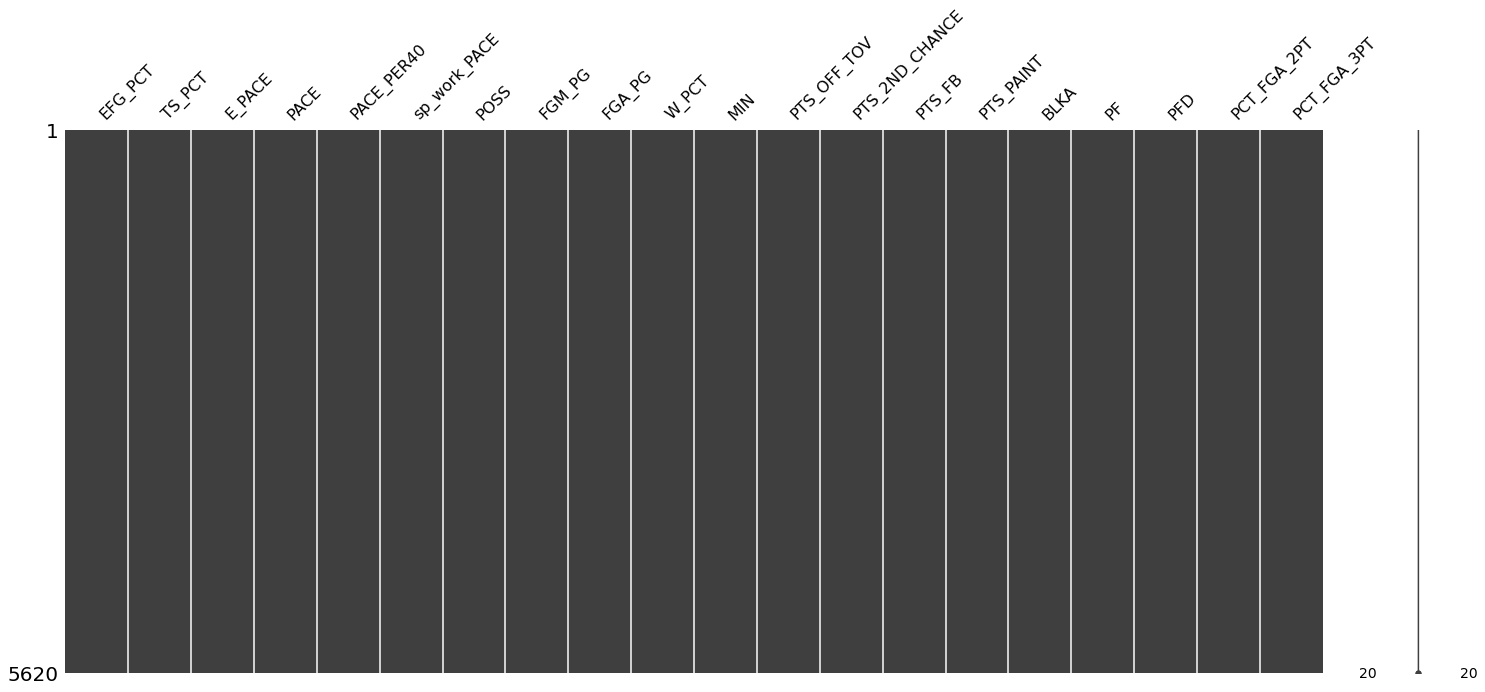

In [30]:
mno.matrix(merged_df.iloc[:,20:40])

In [ ]:
missing_columns = merged_df.columns[merged_df.isnull().any()].tolist()

def random_imputation(df, feature):
    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + "_imp"] = np.random.choice(observed_values, number_missing, replace = True)

    return df

for feature in missing_columns:
    merged_df[feature + "_imp"] = merged_df[feature]
    merged_df = random_imputation(merged_df, feature)

In [12]:
deter_data = pd.DataFrame(columns = ["Det" + name for name in missing_columns])

for feature in missing_columns:
    deter_data["Det" + feature] = merged_df[feature + '_imp']
    parameters = list(set(merged_df.columns[5:]) - set(missing_columns) - {feature + '_imp'})

    model = LinearRegression()
    model.fit(X = merged_df[parameters], y = merged_df[feature + '_imp'])

    deter_data.loc[merged_df[feature].isnull(), "Det" + feature] = model.predict(merged_df[parameters])[merged_df[feature].isnull()]



<Axes: >

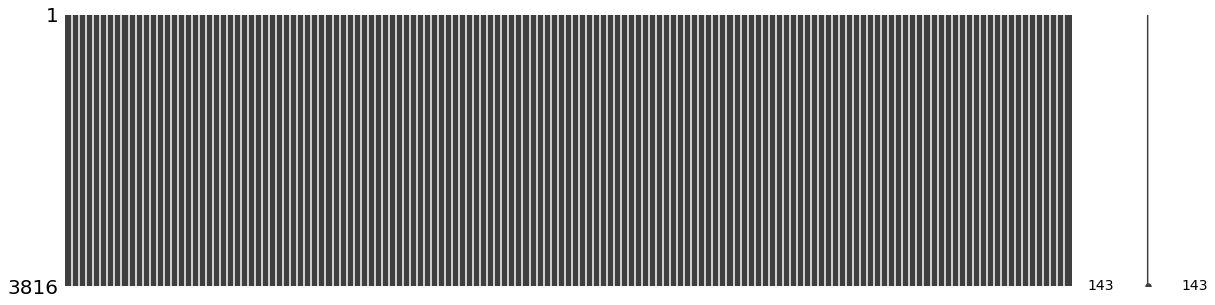

In [13]:
mno.matrix(deter_data, figsize = (20,5))

In [34]:
merged_df.columns

Index(['PLAYER_ID', 'PLAYER_NAME', 'SEASON', 'TEAM_ABBREVIATION', 'TEAM_NAME',
       'AGE', 'FG3M', 'FG3A', 'FG3_PCT', 'FTM',
       ...
       'REB_CHANCE_PCT_ADJ', 'AVG_REB_DIST', 'DIST_FEET', 'DIST_MILES',
       'DIST_MILES_OFF', 'DIST_MILES_DEF', 'AVG_SPEED', 'AVG_SPEED_OFF',
       'AVG_SPEED_DEF', 'LA_RAPM'],
      dtype='object', length=223)

<Axes: xlabel='AVG_SPEED', ylabel='Density'>

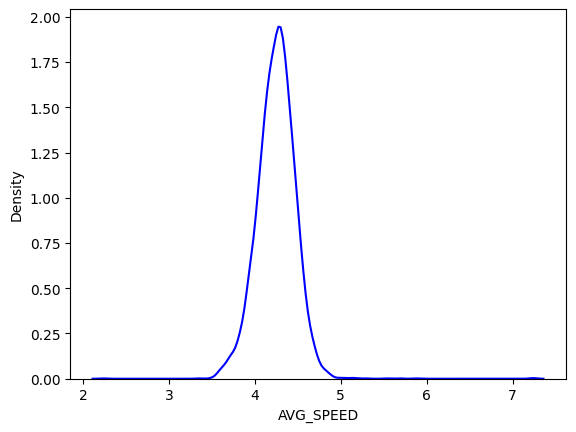

In [25]:
sns.kdeplot(merged_df['AVG_SPEED'], color = 'blue')

# ML Pipeline Setup

In [34]:
merged_df.iloc[:,5:]

,AGE,FG3M,FG3A,FG3_PCT,FTM,FTA,FT_PCT,TOV,AST_PCT,AST_TO,...,REB_CHANCE_PCT_ADJ,AVG_REB_DIST,DIST_FEET,DIST_MILES,DIST_MILES_OFF,DIST_MILES_DEF,AVG_SPEED,AVG_SPEED_OFF,AVG_SPEED_DEF,LA_RAPM
0,22.0,0.7,1.7,0.400,0.1,0.5,0.250,0.2,0.032,0.67,...,0.778,6.1,3155.20,0.60,0.32,0.28,4.64,4.88,4.30,-0.39
1,23.0,1.3,3.0,0.419,0.1,0.1,1.000,0.3,0.092,2.44,...,0.600,8.1,4053.23,0.77,0.42,0.34,4.35,4.73,3.96,-1.25
2,19.0,1.4,3.6,0.390,0.6,0.7,0.894,0.6,0.070,1.74,...,0.619,8.7,8386.26,1.59,0.85,0.74,4.56,4.96,4.17,0.31
3,27.0,0.9,2.5,0.347,2.8,4.6,0.608,1.4,0.129,2.07,...,0.652,5.9,11320.35,2.14,1.12,1.02,3.99,4.22,3.77,2.21
4,26.0,0.6,1.4,0.409,0.4,0.5,0.844,0.6,0.135,2.47,...,0.592,10.1,5413.90,1.03,0.52,0.50,4.27,4.35,4.18,1.10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5691,32.0,0.7,2.2,0.339,0.5,0.6,0.824,0.6,0.090,1.47,...,0.494,9.2,5987.75,1.13,0.59,0.55,4.32,4.58,4.06,0.79
5692,27.0,2.0,5.7,0.348,1.8,2.5,0.724,1.3,0.093,1.44,...,0.512,6.4,11566.52,2.19,1.15,1.04,4.24,4.62,3.90,-1.72
5693,23.0,0.7,1.9,0.346,2.7,4.1,0.655,1.3,0.090,0.89,...,0.399,9.2,8304.98,1.57,0.81,0.76,4.49,4.82,4.20,3.70
5694,32.0,0.0,0.3,0.100,3.2,4.3,0.742,2.3,0.124,1.09,...,0.528,4.7,11672.58,2.21,1.17,1.04,3.88,3.90,3.85,3.30


In [42]:
cor = (
    merged_df.iloc[:,5:].corr()['LA_RAPM']
)

cor.sort_values(ascending=False).iloc[0:29]

LA_RAPM               1.000000
PFD                   0.325189
STL                   0.313834
FTM                   0.311182
POINTS                0.310502
FTA                   0.308089
FGM                   0.306930
PTS_OFF_TOV           0.301528
FGM_PG                0.301125
TOUCHES               0.285587
AST_ADJ               0.281218
FGA                   0.278321
DREB_CHANCES          0.278100
AST                   0.277799
AST_POINTS_CREATED    0.276531
SECONDARY_AST         0.276009
PASSES_MADE           0.271835
PTS_PAINT             0.271185
MIN                   0.269239
FGA_PG                0.266848
POSS                  0.265243
DREB                  0.263953
POTENTIAL_AST         0.263537
REB_UNCONTEST         0.263252
FRONT_CT_TOUCHES      0.262438
DREB_UNCONTEST        0.259827
DIST_MILES_DEF        0.259610
PTS_FB                0.259132
PTS_2ND_CHANCE        0.258723
Name: LA_RAPM, dtype: float64

In [19]:
merged_df.columns

Index(['PLAYER_ID', 'PLAYER_NAME', 'SEASON', 'TEAM_ABBREVIATION', 'TEAM_NAME',
       'Handoff PERCENTILE', 'Handoff POSS_PCT', 'Handoff PPP',
       'Handoff FG_PCT', 'Handoff FT_POSS_PCT',
       ...
       'REB_CHANCE_PCT_ADJ', 'AVG_REB_DIST', 'DIST_FEET', 'DIST_MILES',
       'DIST_MILES_OFF', 'DIST_MILES_DEF', 'AVG_SPEED', 'AVG_SPEED_OFF',
       'AVG_SPEED_DEF', 'LA_RAPM'],
      dtype='object', length=351)

In [43]:
# X = deter_data.iloc[:, :len(deter_data.columns)-1]
# y = deter_data['DetLA_RAPM']

X = merged_df.iloc[:, 5:len(merged_df.columns)-1]
y = merged_df['LA_RAPM']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# summarize all features
for i in range(X.shape[1]):

 print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

In [68]:
# deter_data_selected_features = deter_data.iloc[:,np.where(rfe.ranking_==1)[0]]

In [ ]:
# fig, ax = plt.subplots(1, 8, figsize=(18, 6))

# ast_adj_val = data_dict["Passing"]["AST_ADJ yeo-johnson"].values
# drives_ftm_val = data_dict["Drives"]["DRIVE_FTM yeo-johnson"].values
# pull_up_fgm_val = data_dict["PullUpShot"]["PULL_UP_FGM yeo-johnson"].values
# isolation_fga_pct_val = data_dict["Isolation"]["FGA yeo-johnson"].values
# pfd_val = data_dict["Base"]["PFD yeo-johnson"].values
# pts_val = data_dict["Base"]["PTS yeo-johnson"].values
# usage_val = data_dict["Advanced"]["USG_PCT yeo-johnson"].values
# ts_val = data_dict["Advanced"]["TS_PCT yeo-johnson"].values

# sns.distplot(ast_adj_val, ax=ax[0], color="r")
# ax[0].set_title("Distribution of Assists Adjusted", fontsize=6)
# ax[0].set_xlim([min(ast_adj_val), max(ast_adj_val)])

# sns.displot(drives_ftm_val, ax=ax[1], color="r")
# ax[1].set_title("FTM off Drives", fontsize=6)
# ax[1].set_xlim([min(drives_ftm_val), max(drives_ftm_val)])

# sns.distplot(pull_up_fgm_val, ax=ax[2], color="r")
# ax[2].set_title("Pull Up FGM", fontsize=6)
# ax[2].set_xlim([min(pull_up_fgm_val), max(pull_up_fgm_val)])

# sns.distplot(pfd_val, ax=ax[3], color="r")
# ax[3].set_title("Distribution of Points", fontsize=6)
# ax[3].set_xlim([min(pfd_val), max(pfd_val)])

# sns.distplot(pts_val, ax=ax[4], color="r")
# ax[4].set_title("Distribution of 3-Point FG%", fontsize=6)
# ax[4].set_xlim([min(pts_val), max(pts_val)])

# sns.distplot(usage_val, ax=ax[5], color="r")
# ax[5].set_title("Distribution of 3-Point Attempt Rate", fontsize=6)
# ax[5].set_xlim([min(usage_val), max(usage_val)])

# sns.distplot(ts_val, ax=ax[6], color="r")
# ax[6].set_title("Distribution of FT Rate", fontsize=6)
# ax[6].set_xlim([min(ts_val), max(ts_val)])


# plt.show()

In [38]:
# Transform the data using Yeo-Johnson transform
def yeo_johnson_transform(data):
    pt = PowerTransformer(method="yeo-johnson", standardize=True)
    transformed_data = pt.fit_transform(data.values.reshape(-1, 1))
    return transformed_data

In [ ]:
%store data_dict rapm_total_df la_rapm_total_df X_train X_test y_train y_test

In [ ]:

set_config(display="diagram")
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('yeo-johnson',
                                 Pipeline(steps=[('powertransformer',
                                                  PowerTransformer())]),
                                 ['DRIVE_FTM', 'AST_ADJ', 'PFD', 'PTS',
                                  'USG_PCT', 'TS_PCT'])])

In [39]:
memory = Memory(location="cache", verbose=0)

estimators = {
    # "randomforestregressor": RandomForestRegressor(),
    "xgboost": xgb.XGBRegressor(),
    "sgdregressor": SGDRegressor(),
    "lasso": Lasso(),
    "ridge": Ridge(),
}

param_grid = {
    # "randomforestregressor": {
    #     "n_estimators": [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000],
    #     "max_depth": [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    #     "min_samples_split": [2, 5, 10],
    #     "min_samples_leaf": [1, 2, 4],
    #     "bootstrap": [True, False],
    #     "max_features": np.arange(1,150, 10),
    # },
    "xgboost" : {
        'max_depth': [3, 5, 6, 10, 15, 20],
        'learning_rate': np.arange(0.01, 0.3, 0.1),
        'subsample': np.arange(0.5, 1.0, 0.1),
        'colsample_bytree': np.arange(0.4, 1.0, 0.1),
         'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
         'n_estimators': [100, 500, 1000]
    },
    'sgdregressor' : {
                "penalty": ['l1', 'l2', 'elasticnet'], \
                "alpha": np.logspace(-4, 0, 30),\
                "l1_ratio": list(np.arange(0, 1, 0.1)),
                "learning_rate": ['optimal', 'adaptive', 'invscaling'],
                "eta0": list(np.arange(0.01, 1, 0.1)),
                "tol": list(np.arange(0.0001, 0.01, 0.001)),
                "max_iter": list(np.arange(50, 1000, 100))
                                    },
                                    
    "lasso": {
        "alpha":  np.logspace(-4, 0, 30),
        "selection": ['cyclic', 'random'],
        "tol": list(np.arange(0.0001, 0.01, 0.001)),
        "max_iter": list(np.arange(50, 1000, 100))
    },
    "ridge": {
        "alpha": np.logspace(-4, 0, 30),
        "solver": ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga'],
        "tol": list(np.arange(0.0001, 0.01, 0.001))}
}

In [45]:
# scores = {}
# mse_values = []
# r2_values = []

# pipe_yeo_johnson = make_pipeline(
#     PowerTransformer(method="yeo-johnson", standardize=True)
# )

# for regressor_name, regressor in estimators.items():
#     print("Training {}...".format(regressor_name))
#     # pipe = Pipeline(
#     #     steps=[("preprocessor", preprocessor), (regressor_name, regressor)],
#     #     memory=memory,
#     # )
#     # pipe = Pipeline(steps=[(regressor_name, regressor)], memory=memory)
#     kfold = KFold(n_splits=5, shuffle=True, random_state=40)

#     for train_index, test_index in kfold.split(X_train, y_train):
#         X_train_kfold, X_test_kfold = (
#             X_train.iloc[list(train_index)],
#             X_train.iloc[list(test_index)],
#         )
#         y_train_kfold, y_test_kfold = (
#             y_train.iloc[list(train_index)],
#             y_train.iloc[list(test_index)],
#         )


#         columns = list(X_train_kfold.columns)

#         skews = []
#         skew_after_transform = []
#         diff_skews = []
#         for column in columns:
#             # sns.kdeplot(X_train[column])
#             skews.append((column, X_train_kfold[column].skew()))

#             pt = PowerTransformer(method="yeo-johnson")
#             data = pt.fit_transform(X_train_kfold[column].values.reshape(-1, 1))
#             data = [item for sublist in data for item in sublist]
#             skew_after_transform.append((column, pd.Series(data).skew()))

#             diff_skews.append((column, pd.Series(data).skew() - X_train_kfold[column].skew()))

#         result = list(filter(lambda x: abs(x[1]) >= 0.5, diff_skews))
#         columns_transform = [x[0] for x in result]

#         cols_yeo_johnson = columns_transform
#         preprocessor = ColumnTransformer(
#             transformers=[("yeo-johnson", pipe_yeo_johnson, cols_yeo_johnson)],
#             remainder="passthrough",
#         )

#         print("Columns are transformed for {}".format(regressor_name))
        
#         X_train_kfold = preprocessor.fit_transform(X_train_kfold)
#         X_test_kfold = preprocessor.transform(X_test_kfold)


#         # define RFE
#         rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=100)
#         # fit RFE
#         rfe.fit(X_train_kfold, y_train_kfold)
#         # summarize all features
#         # for i in range(X.shape[1]):

#         #     print('Column: %d, Selected %s, Rank: %.3f' % (i, rfe.support_[i], rfe.ranking_[i]))

#         X_train_kfold = pd.DataFrame(X_train_kfold).iloc[:,np.where(rfe.ranking_==1)[0]]
#         X_test_kfold = pd.DataFrame(X_test_kfold).iloc[:,np.where(rfe.ranking_==1)[0]]

#         print("RFE is done for {}".format(regressor_name))


#         rand_search = RandomizedSearchCV(
#             regressor,
#             param_distributions=param_grid[regressor_name],
#             n_iter=60,
#             cv=5,
#             scoring=["r2"],
#             refit="r2",
#             error_score="raise",
#             n_jobs=5,
#             verbose=0,
#             random_state=40,
#         )
#         rand_search.fit(X_train_kfold, y_train_kfold)
#         y_pred = rand_search.predict(X_test_kfold)

#         print("RandomizedSearchCV is done for {}".format(regressor_name))

#         mse = mean_squared_error(y_test_kfold, y_pred)
#         r2 = r2_score(y_test_kfold, y_pred)

#         r2_values.append(r2)
#         mse_values.append(mse)

#         print("\n The best estimator across ALL searched params:\n", rand_search.best_estimator_)
#         print("\n The best score across ALL searched params:\n", rand_search.best_score_)
#         print("\n The best parameters across ALL searched params:\n", rand_search.best_params_)

#     scores[regressor_name] = [np.mean(mse), np.mean(r2)]

#     print("Best {} parameters: {}".format(regressor_name, rand_search.best_params_))
#     print("Best {} score: {}".format(regressor_name, rand_search.best_score_))

Training xgboost...
Columns are transformed for xgboost


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold, RandomizedSearchCV
from sklearn.preprocessing import PowerTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Initialize dictionaries and lists to store results
scores = {}
mse_values = []
r2_values = []

# Predefined pipeline for Yeo-Johnson transformation
pipe_yeo_johnson = make_pipeline(PowerTransformer(method="yeo-johnson", standardize=True))

# Iterate through each regressor in the estimators dictionary
for regressor_name, regressor in estimators.items():
    print(f"Training {regressor_name}...")
    
    # K-Fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=40)
    
    for train_index, test_index in kfold.split(X_train, y_train):
        X_train_kfold, X_test_kfold = X_train.iloc[train_index], X_train.iloc[test_index]
        y_train_kfold, y_test_kfold = y_train.iloc[train_index], y_train.iloc[test_index]

        columns = X_train_kfold.columns
        skews, skew_after_transform, diff_skews = [], [], []
        
        # Transform and check skewness of each feature
        for column in columns:
            skews.append((column, X_train_kfold[column].skew()))
            pt = PowerTransformer(method="yeo-johnson")
            data = pt.fit_transform(X_train_kfold[column].values.reshape(-1, 1)).flatten()
            skew_after_transform.append((column, pd.Series(data).skew()))
            diff_skews.append((column, pd.Series(data).skew() - X_train_kfold[column].skew()))

        # Select columns to transform
        columns_transform = [x[0] for x in diff_skews if abs(x[1]) >= 0.5]
        
        preprocessor = ColumnTransformer(
            transformers=[("yeo-johnson", pipe_yeo_johnson, columns_transform)],
            remainder="passthrough"
        )

        print(f"Columns are transformed for {regressor_name}")
        
        # Apply preprocessing
        X_train_kfold = preprocessor.fit_transform(X_train_kfold)
        X_test_kfold = preprocessor.transform(X_test_kfold)

        # Recursive Feature Elimination (RFE)
        rfe = RFE(estimator=DecisionTreeRegressor(), n_features_to_select=100)
        rfe.fit(X_train_kfold, y_train_kfold)
        selected_features = np.where(rfe.support_)[0]

        X_train_kfold = pd.DataFrame(X_train_kfold).iloc[:, selected_features]
        X_test_kfold = pd.DataFrame(X_test_kfold).iloc[:, selected_features]

        print(f"RFE is done for {regressor_name}")

        # Hyperparameter tuning with RandomizedSearchCV
        rand_search = RandomizedSearchCV(
            regressor,
            param_distributions=param_grid[regressor_name],
            n_iter=60,
            cv=5,
            scoring='r2',
            refit='r2',
            error_score='raise',
            n_jobs=5,
            verbose=0,
            random_state=40,
        )
        rand_search.fit(X_train_kfold, y_train_kfold)
        y_pred = rand_search.predict(X_test_kfold)

        print(f"RandomizedSearchCV is done for {regressor_name}")

        mse = mean_squared_error(y_test_kfold, y_pred)
        r2 = r2_score(y_test_kfold, y_pred)

        mse_values.append(mse)
        r2_values.append(r2)

        print(f"\nThe best estimator across ALL searched params:\n{rand_search.best_estimator_}")
        print(f"\nThe best score across ALL searched params:\n{rand_search.best_score_}")
        print(f"\nThe best parameters across ALL searched params:\n{rand_search.best_params_}")

    # Calculate mean MSE and R² for the regressor
    scores[regressor_name] = [np.mean(mse_values), np.mean(r2_values)]

    print(f"Best {regressor_name} parameters: {rand_search.best_params_}")
    print(f"Best {regressor_name} score: {rand_search.best_score_}")

# Display final scores
for regressor_name, score in scores.items():
    print(f"{regressor_name}: MSE = {score[0]:.4f}, R² = {score[1]:.4f}")


In [29]:
r2_values

[0.2739432211110344,
 0.24130849820828704,
 0.28272516930590763,
 0.25337018299118763,
 0.2301389346783398,
 0.17944033552468586,
 0.14289391383829464,
 0.20342289781984502,
 0.15283284913395556,
 0.14894154816982452,
 0.18845011709807336,
 0.14346464769788336,
 0.18399507871309095,
 0.15954180335458867,
 0.15930479742305426,
 0.1801662847069352,
 0.14892443737433259,
 0.1688480754790851,
 0.1575213687694187,
 0.15077159672611462]

In [53]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'linearregression', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [8]:
rand_search.cv_results_

AttributeError: 'RandomizedSearchCV' object has no attribute 'cv_results_'

In [ ]:
pipe.get_params().keys()

dict_keys(['memory', 'steps', 'verbose', 'preprocessor', 'linearregression', 'preprocessor__n_jobs', 'preprocessor__remainder', 'preprocessor__sparse_threshold', 'preprocessor__transformer_weights', 'preprocessor__transformers', 'preprocessor__verbose', 'preprocessor__verbose_feature_names_out', 'preprocessor__yeo-johnson', 'preprocessor__yeo-johnson__memory', 'preprocessor__yeo-johnson__steps', 'preprocessor__yeo-johnson__verbose', 'preprocessor__yeo-johnson__powertransformer', 'preprocessor__yeo-johnson__powertransformer__copy', 'preprocessor__yeo-johnson__powertransformer__method', 'preprocessor__yeo-johnson__powertransformer__standardize', 'linearregression__copy_X', 'linearregression__fit_intercept', 'linearregression__n_jobs', 'linearregression__normalize', 'linearregression__positive'])

In [ ]:
y_test

3311    -0.33
1034     -0.1
2331     0.01
3334    -0.03
33       -0.2
        ...  
2763     0.01
360     -0.83
2529    -0.64
1623     0.13
4312    -1.08
Name: LA_RAPM__Off, Length: 926, dtype: object

In [ ]:
# player_la_rapm_general_stats_total_df = player_la_rapm_general_stats_total_df[['PLAYER_ID', 'PLAYER_NAME', 'TEAM_ID', 'TEAM_ABBREVIATION','LA_RAPM',\
#                                                                                 'LA_RAPM__Off', 'LA_RAPM__Def', 'SEASON', 'GP', 'MIN', 'FG3A', 'FG3_PCT',\
#                                                                                       'FTA', 'FT_PCT', 'OREB', 'DREB', 'REB', 'AST', 'TOV', 'STL',\
#                                                                                 'BLK', 'PF', 'PFD', 'PTS', 'PLUS_MINUS']]

# player_la_rapm_general_stats_total_df.drop_duplicates(inplace=True)
# player_la_rapm_general_stats_total_df.reset_index(drop=True,inplace=True)
# player_la_rapm_general_stats_total_df = player_la_rapm_general_stats_total_df[(player_la_rapm_general_stats_total_df['GP']>=30)\
#                                                                               & (player_la_rapm_general_stats_total_df['MIN']>=10)]

# player_la_rapm_general_stats_total_df.reset_index(drop=True,inplace=True)
# player_la_rapm_general_stats_total_df.rename(columns = {'TEAM_ABBREVIATION': 'Team', 'PLAYER_NAME': 'Player'}, inplace = True)
# player_la_rapm_general_stats_advanced_bball_ref_total_stats = player_la_rapm_general_stats_total_df\
#     .merge(player_advanced_bball_ref_total_df, on = ['Team', 'Player', 'SEASON'])

# X = player_la_rapm_general_stats_advanced_bball_ref_total_stats[['3PAr','FG3_PCT', 'PF',
#        'USG%', 'FT_PCT yeo-johnson', 'PFD yeo-johnson',
#        'PTS yeo-johnson', 'STL% yeo-johnson', 'TOV yeo-johnson',
#        'TRB% yeo-johnson', 'REB yeo-johnson', 'FG3A yeo-johnson',
#        'FTA yeo-johnson', 'BLK yeo-johnson', 'BLK% yeo-johnson',
#        'AST yeo-johnson', 'AST% yeo-johnson', 'FTr yeo-johnson']]

# y = player_la_rapm_general_stats_advanced_bball_ref_total_stats ['LA_RAPM__Off']

# data = player_la_rapm_general_stats_advanced_bball_ref_total_stats[['3PAr','FG3_PCT', 'PF',
#        'USG%', 'FT_PCT yeo-johnson', 'PFD yeo-johnson',
#        'PTS yeo-johnson', 'STL% yeo-johnson', 'TOV yeo-johnson',
#        'TRB% yeo-johnson', 'REB yeo-johnson', 'FG3A yeo-johnson',
#        'FTA yeo-johnson', 'BLK yeo-johnson', 'BLK% yeo-johnson',
#        'AST yeo-johnson', 'AST% yeo-johnson', 'FTr yeo-johnson', 'LA_RAPM__Off']]



In [ ]:
# fig, ax = plt.subplots(1, 8, figsize = (18,6))

# reb_val = X['REB yeo-johnson'].values
# ast_val = X['AST% yeo-johnson'].values
# # plus_minus_val = X['PLUS_MINUS'].values
# points_val = X['PTS yeo-johnson'].values
# fg3_pct_val = X['FG3_PCT'].values
# usg_pct_val = X['USG%']
# fg3_attempt_rate_val = X['3PAr']
# ft_rate_val = X['FTr yeo-johnson']
# block_val = X['BLK yeo-johnson']

# sns.distplot(reb_val, ax = ax[0], color = 'r')
# ax[0].set_title('Distribution of Rebounds', fontsize = 6)
# ax[0].set_xlim([min(reb_val), max(reb_val)])

# sns.distplot(ast_val, ax = ax[1], color = 'r')
# ax[1].set_title('Distribution of Assists', fontsize = 6)
# ax[1].set_xlim([min(ast_val), max(ast_val)])

# sns.distplot(usg_pct_val, ax = ax[2], color = 'r')
# ax[2].set_title('Distribution of Usage', fontsize = 6)
# ax[2].set_xlim([min(usg_pct_val), max(usg_pct_val)])

# sns.distplot(points_val, ax = ax[3], color = 'r')
# ax[3].set_title('Distribution of Points', fontsize = 6)
# ax[3].set_xlim([min(points_val), max(points_val)])

# sns.distplot(fg3_pct_val, ax = ax[4], color = 'r')
# ax[4].set_title('Distribution of 3-Point FG%', fontsize = 6)
# ax[4].set_xlim([min(fg3_pct_val), max(fg3_pct_val)])

# sns.distplot(fg3_attempt_rate_val, ax = ax[5], color = 'r')
# ax[5].set_title('Distribution of 3-Point Attempt Rate', fontsize = 6)
# ax[5].set_xlim([min(fg3_attempt_rate_val), max(fg3_attempt_rate_val)])

# sns.distplot(ft_rate_val, ax = ax[6], color = 'r')
# ax[6].set_title('Distribution of FT Rate', fontsize = 6)
# ax[6].set_xlim([min(ft_rate_val), max(ft_rate_val)])

# sns.distplot(block_val, ax = ax[7], color = 'r')
# ax[7].set_title('Distribution of Blocks', fontsize = 6)
# ax[7].set_xlim([min(block_val), max(block_val)])


# plt.show()

In [ ]:
pd.read_html("https://dunksandthrees.com/")

[   Unnamed: 0_level_0 Unnamed: 1_level_0     RATINGS                          \
                  Team                W-L        aNET       aORTG       aDRTG   
 0                1BOS              43-12    +9.6 \t1   120.9 \t1   111.4 \t3   
 1                1MIN              39-16    +6.9 \t2  116.0 \t16   109.1 \t1   
 2                2OKC              37-17    +6.6 \t3   119.3 \t4   112.7 \t5   
 3                2CLE              36-17    +5.0 \t4  116.0 \t17   111.0 \t2   
 4                3LAC              36-17    +5.0 \t5   119.8 \t2  114.8 \t13   
 5                6NOP              33-22    +4.3 \t6  117.6 \t13   113.3 \t7   
 6                4NYK              33-22    +4.1 \t7  118.0 \t10  113.9 \t10   
 7                4DEN              36-19    +3.8 \t8  117.9 \t11  114.1 \t11   
 8                5PHI              32-22    +3.3 \t9   118.1 \t8  114.8 \t12   
 9                5PHX              33-22   +2.1 \t10  117.7 \t12  115.7 \t15   
 10              10GSW      